# Cruce de variables

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

Primero debemos cargar las tablas de datos. En particular utilizaremos `emociones`, `contribuciones`, `necesidades pais` y `necesidades personales/familiares`

In [2]:
emociones      = pd.read_csv('./data/emotions.csv', low_memory=False)
pais_need      = pd.read_csv('./data/country_needs.csv', low_memory=False)
personal_need  = pd.read_csv('./data/personal_needs.csv', low_memory=False)
contribuciones = pd.read_csv('./data/contributions.csv', low_memory=False)

Ocuparemos la columna `macro` en cada tabla. Esta columna es una categorizacion la cual se explica en el informe de este proyecto.

### Necesidades vs Emociones 

En este punto buscamos contestar la pregunta: **Que necesidades estan asociadas ciertas emociones?**.

En particular, debemos: 
1. agrupar la tabla de emociones por `macro`-emocion y luego, 
2. con los ids de individuos (`ind_id`) y dialogos (`diag_id`) buscar las necesidades.

In [3]:
def get_cruce(frame_pivote, frame_dependiente, normed=False, n_top=100):
    pivote_agrupado = frame_pivote.groupby('macro')
    count = 0
    for nombre, frame in pivote_agrupado:
        frame = frame[frame['macro'] != 'NR']
        frame_dependiente = frame_dependiente[frame_dependiente['macro'] != 'NR']

        indv = frame_dependiente[frame_dependiente['ind_id'].isin(frame['ind_id'])]
        diag = frame_dependiente[frame_dependiente['diag_id'].isin(frame['diag_id'])]
        both = pd.concat([indv, diag])

        top_ind = get_top(indv['macro'], normalize=normed)[:n_top]
        top_diag = get_top(diag['macro'], normalize=normed)[:n_top]
        top_all = get_top(both['macro'], normalize=normed)[:n_top]
        
        yield top_ind, top_diag, top_all, nombre

La funcion `get_cruce` recibe un `frame_pivote` sobre el cual queremos agrupar (i.e., tabla de emociones); ademas tenemos un `frame_dependiente` el cual nos entregara la informacion a desplegar (i.e., tabla de necesidades). 

Notese que la funcion retorna encuestas individuales (`top_ind`) y dialogos (`top_diag`) por separado; ademas de `top_all` que agrupa las dos tablas anteriores. 

In [10]:
def get_top(column_macro, normalize=False):
    'Recibe una columna y devuelve un frame con la frecuencia de cada valor unico'
    return column_macro.value_counts(normalize=normalize).sort_values(ascending=False)

y ahora para visualizar: 

In [34]:
def visualizar_top_cruce(frame_pivote, frame_dependiente, normed=False, n_top=100, title=''):
    frame_pivote = frame_pivote[frame_pivote['macro'] != 'NR']
    fig, axes = plt.subplots(len(frame_pivote['macro'].unique()), 3, figsize=(15,25), sharey=True)
    count = 0
    for top_diag, top_ind, top_all, macro in get_cruce(frame_pivote, frame_dependiente, normed=normed, n_top=n_top):  
        x = range(len(top_diag.values))
        axes[count][0].bar(x, top_diag.values, color='darkblue')
        axes[count][0].set_xticks(x)
        axes[count][0].set_xticklabels(top_diag.index, rotation=45)
        axes[count][0].set_ylabel('Frecuencia')
        if count == 0: axes[count][0].set_title('Dialogos')

        x = range(len(top_ind.values))
        axes[count][1].bar(x, top_ind.values, color='darkblue')
        axes[count][1].set_xticks(x)
        axes[count][1].set_xticklabels(top_ind.index, rotation=45)
        if count == 0: axes[count][1].set_title('Individuales')

        x = range(len(top_all.values))
        axes[count][2].bar(x, top_all.values, color='darkblue')
        axes[count][2].set_xticks(x)
        axes[count][2].set_xticklabels(top_all.index, rotation=45)
        ax2 = axes[count][2].twinx()
        ax2.set_yticks([])
        ax2.set_ylabel(macro)

        if count == 0: axes[count][2].set_title('Dialogos + Individuales')

        count+=1

    fig.tight_layout()
    fig.suptitle(title, x=0.5, y=1.01, fontsize=15)
    return fig

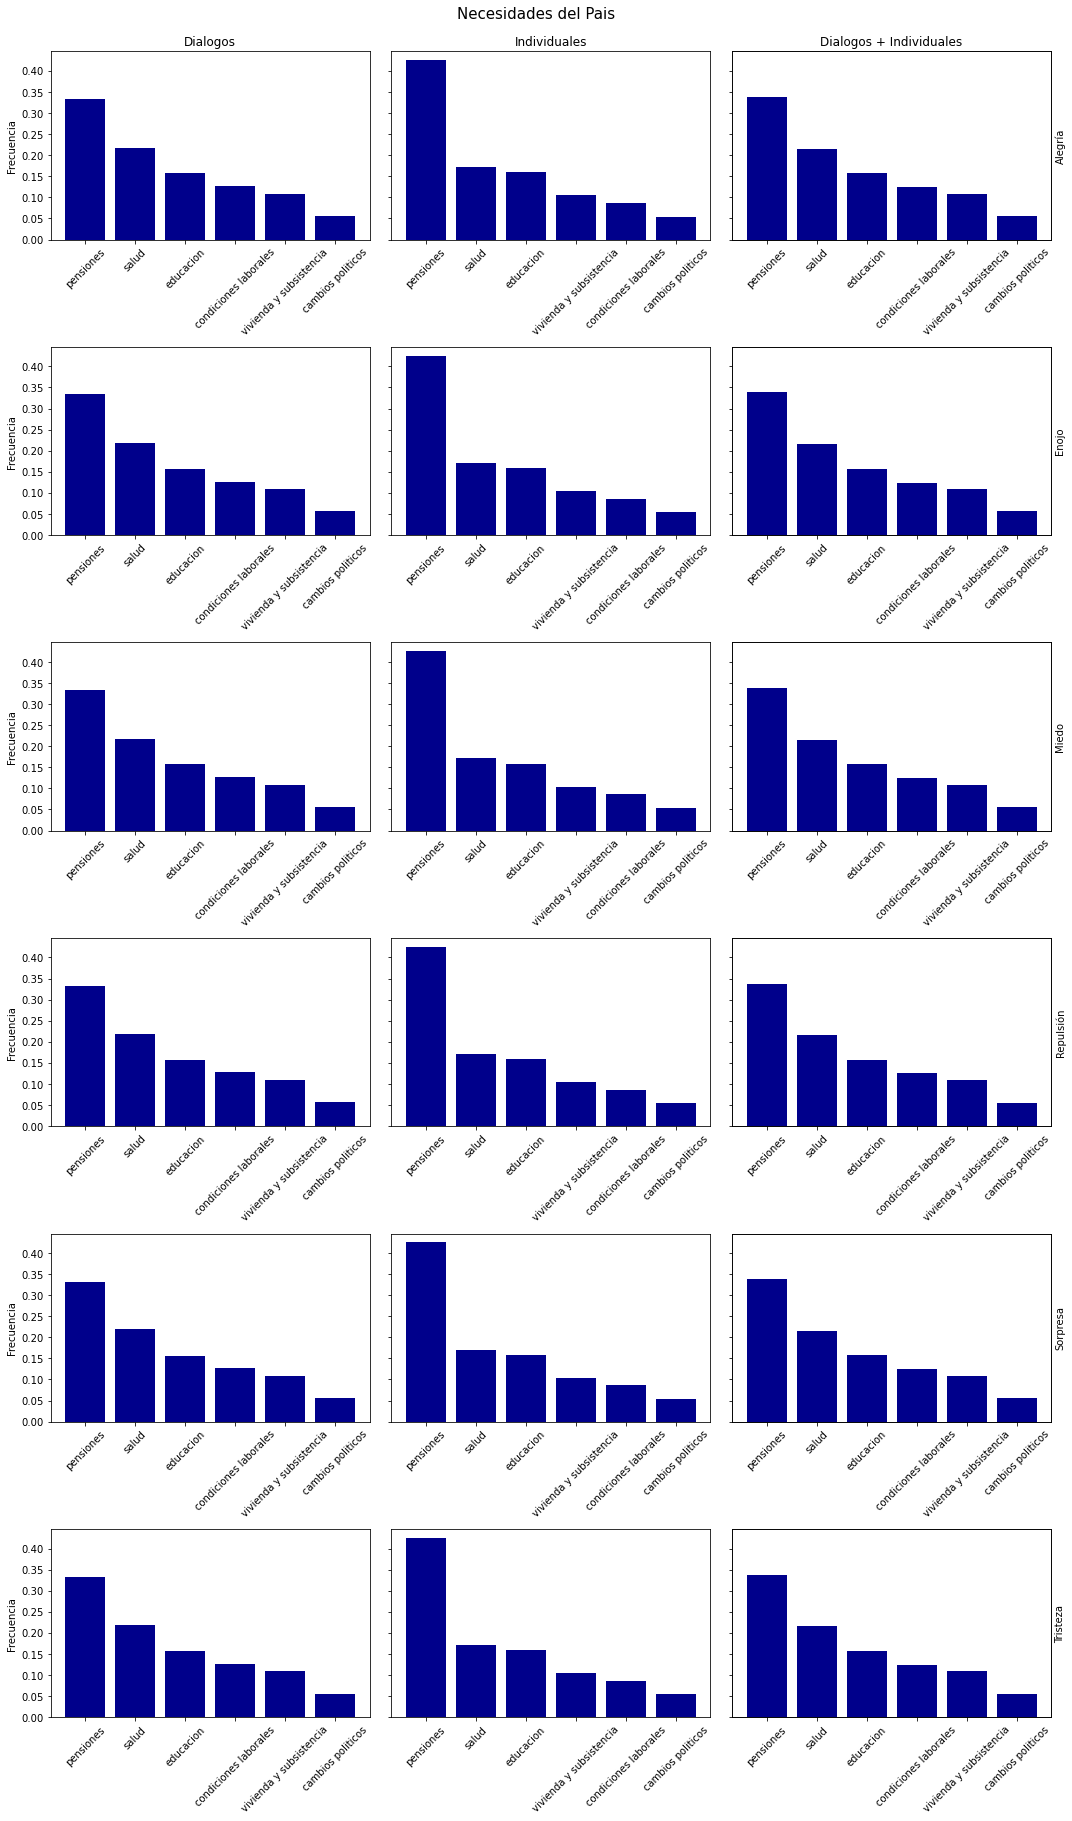

In [25]:
fig = visualizar_top_cruce(emociones, pais_need, normed=True, title='Necesidades del Pais')

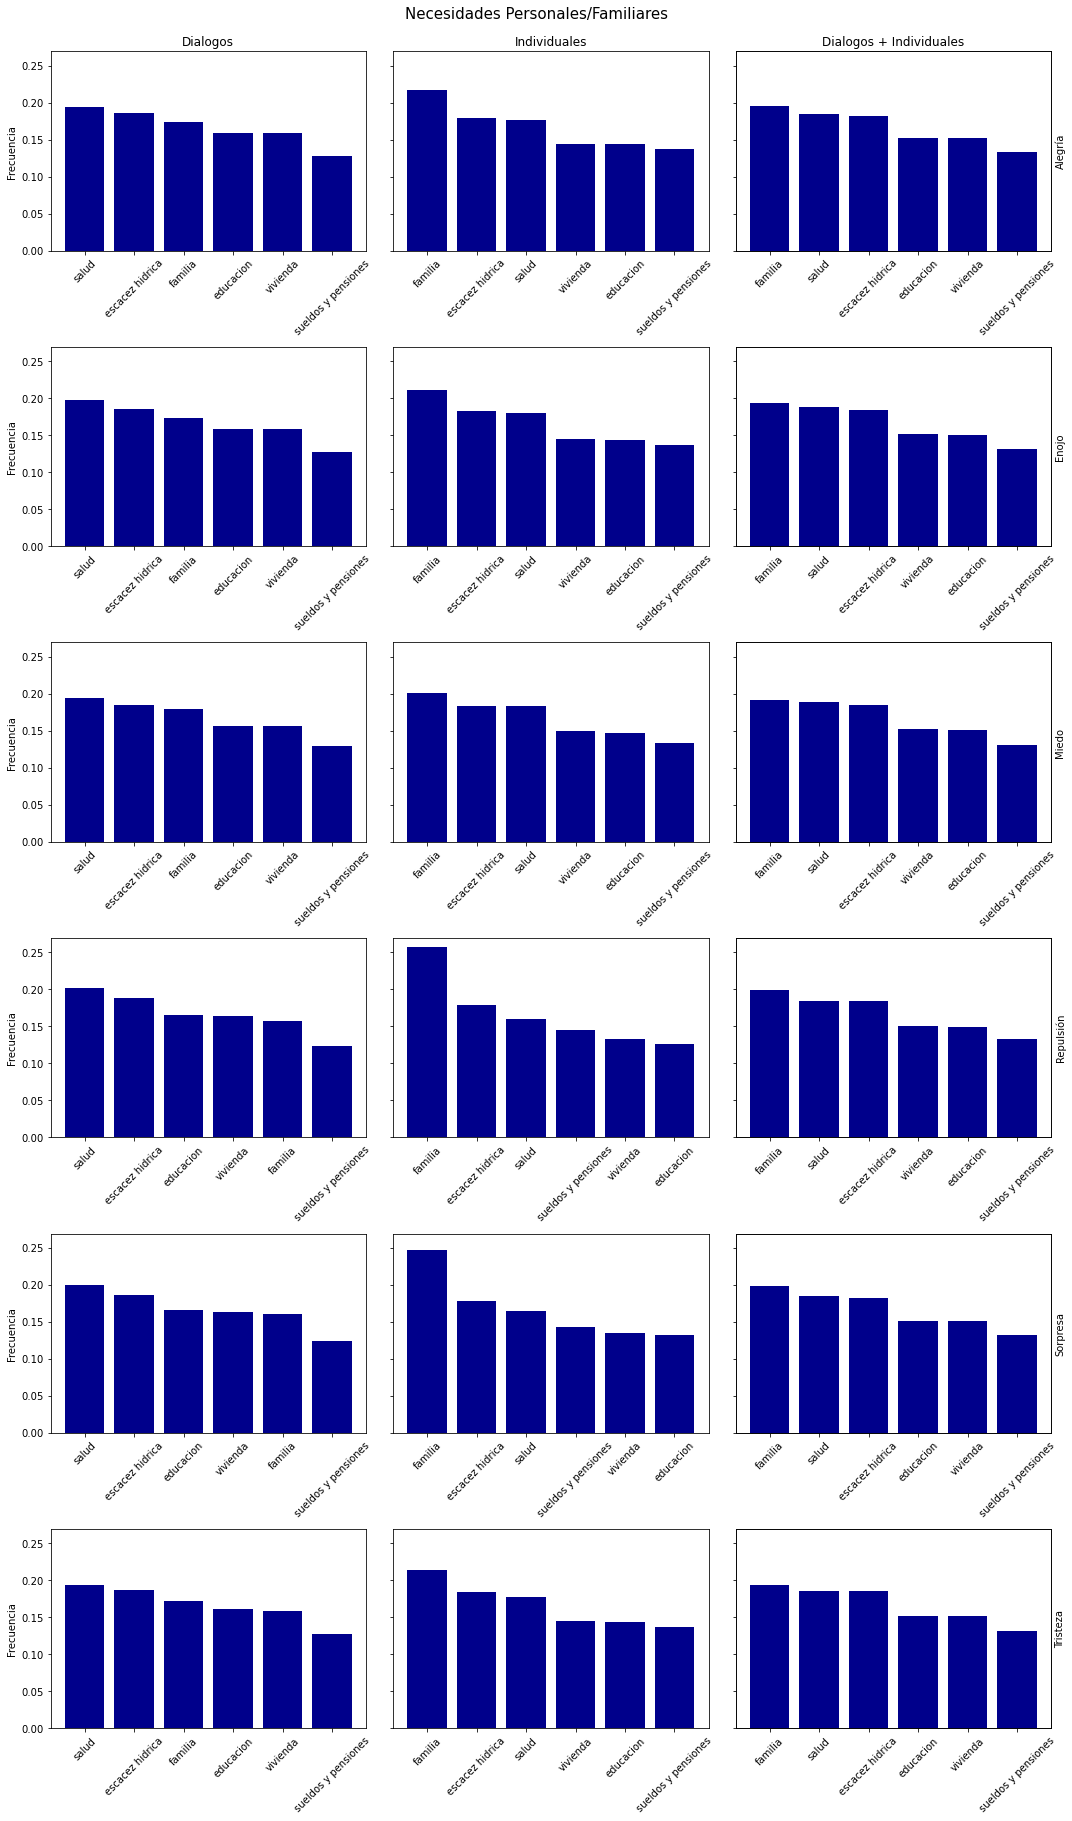

In [26]:
fig = visualizar_top_cruce(emociones, personal_need, normed=True, title='Necesidades Personales/Familiares')

### Otro caso de prueba: Necesidades vs Contribuciones

In [33]:
personal_need['macro'].unique()

array(['escacez hidrica', 'salud', 'familia', 'sueldos y pensiones',
       'educacion', 'vivienda', 'NR'], dtype=object)

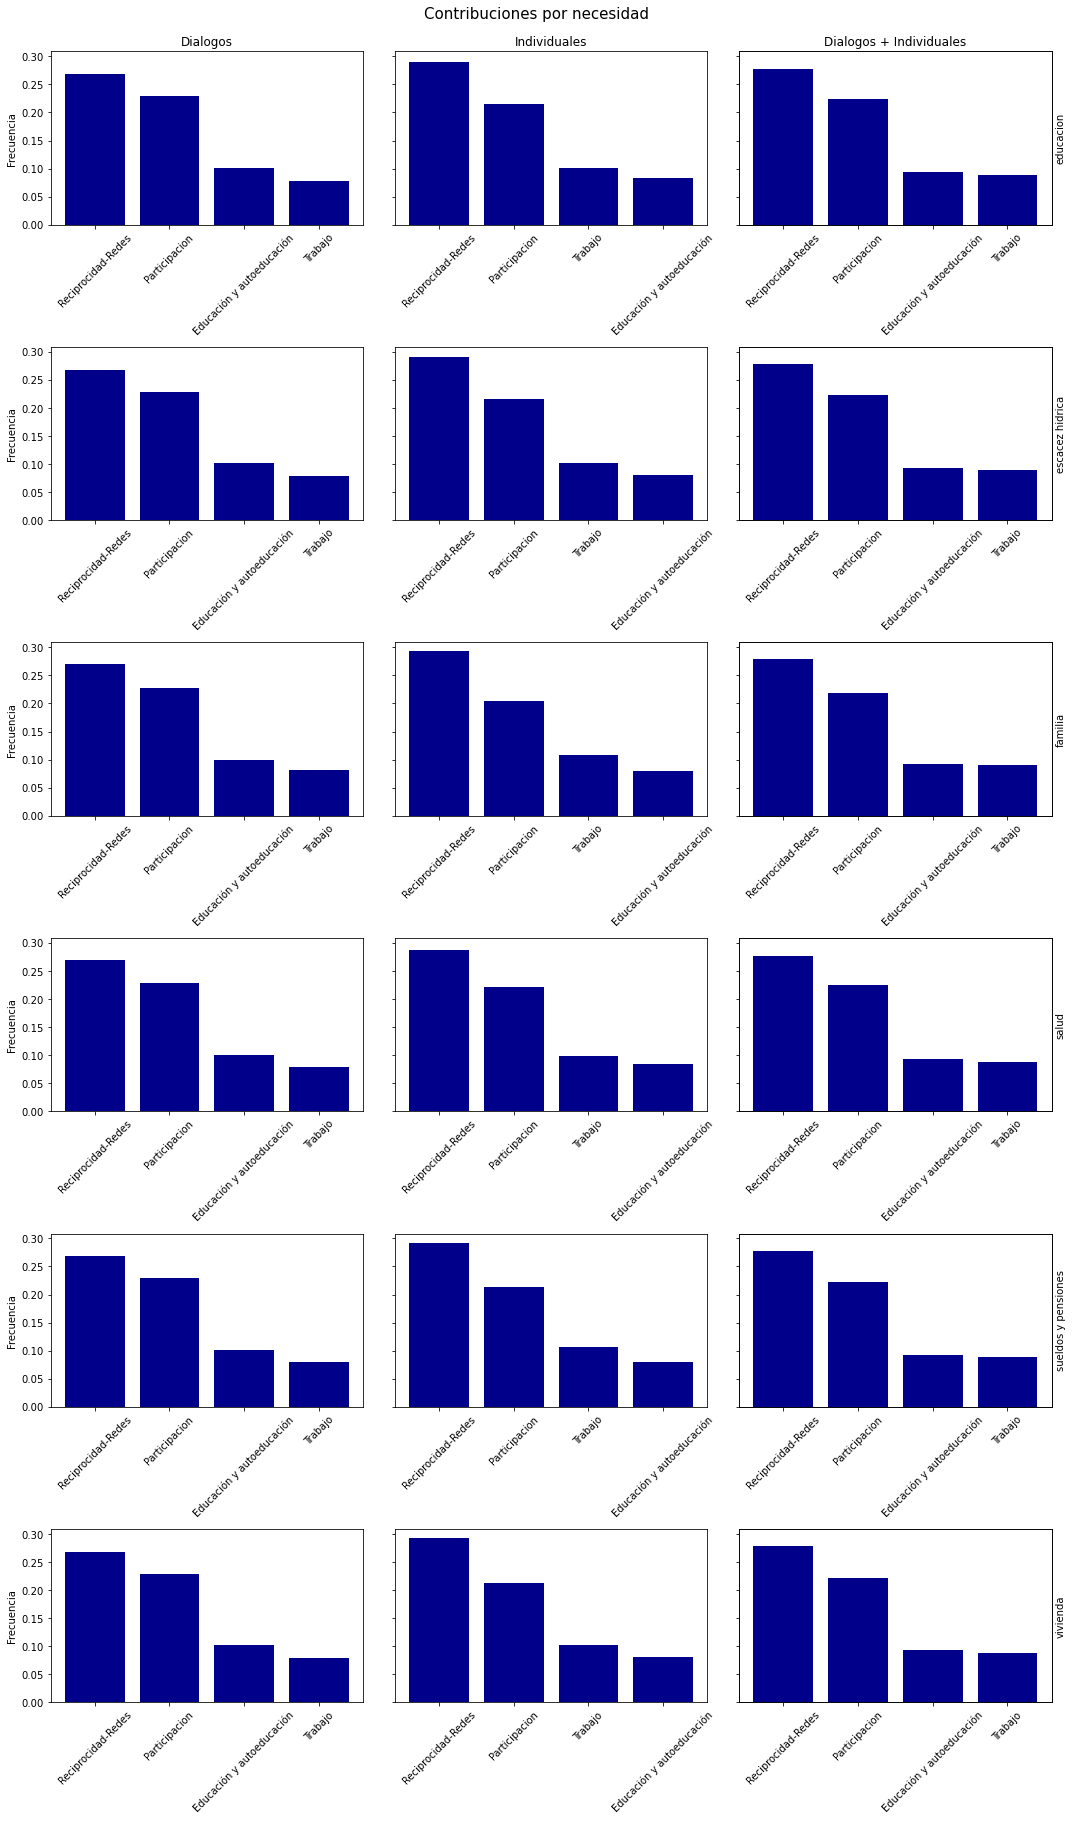

In [35]:
fig = visualizar_top_cruce(personal_need, contribuciones, 
                           normed=True, title='Contribuciones por necesidad', n_top=4)

# Explicaciones

In [24]:
def get_cruce_v2(frame_pivote, frame_dependiente, normed=False, n_top=100):
    pivote_agrupado = frame_pivote.groupby('macro')
    count = 0
    for nombre, frame in pivote_agrupado:
        frame = frame[frame['macro'] != 'NR']
        frame_dependiente = frame_dependiente[frame_dependiente['macro'] != 'NR']

        indv = frame_dependiente[frame_dependiente['ind_id'].isin(frame['ind_id'])]
        diag = frame_dependiente[frame_dependiente['diag_id'].isin(frame['diag_id'])]
        
        both = pd.concat([indv, diag])

        top_ind = get_top(indv['macro'], normalize=normed)[:n_top]
        top_diag = get_top(diag['macro'], normalize=normed)[:n_top]
        top_all = get_top(both['macro'], normalize=normed)[:n_top]
        
        yield top_ind, top_diag, top_all, nombre, both

In [25]:
f = get_cruce_v2(emociones, pais_need, normed=True, n_top=3)

In [26]:
top_ind, top_diag, top_all, nombre, both = next(f) # Tomaremos solo uno para ejemplificar

In [29]:
both.sample(1)

,id,diag_id,ind_id,name,name_tokens,macro,exp,exp_tokens,role,role_tokens,actor,priority,is_online
81211,81211,enc_u_4553396888508439576,NaN,respuesta sin completar,"['respuesta', 'completar']",pensiones,respuesta sin completar,"['respuesta', 'completar']",respuesta sin completar,"['respuesta', 'completar']",respuesta sin completar,0.0,0


Al momento de guardar el `.csv` las listas pasan a ser `strings`, por lo tanto debemos volver la/las columnas con tokens a `listas`. La siguiente funcion realizar la conversion:

In [ ]:
def clean_alt_list(list_):
    '''Formatea un string a lista'''
    list_ = str(list_)
    list_ = list_.replace('[', '')
    list_ = list_.replace(']', '')
    list_ = list_.replace("'", '')
    list_ = list_.split(',')
    return list_

Ahora utilizamos `clean_alt_list` para formatear la columna

In [ ]:
both['exp_tokens'] = both['exp_tokens'].apply(lambda x: clean_alt_list(x))

Finalmente, utilizaremos `wordcloud` para visualizar una nube de palabras

In [50]:
from wordcloud import WordCloud, STOPWORDS

`WordCloud` admite una **entrada de texto plano** que tenga las palabras a desplegar. En este caso debemos juntar las palabras desde los la columna `exp_tokens`

In [52]:
text = ''.join([xx for x in both['exp_tokens'] for xx in x])

In [54]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(40, 30))
    plt.imshow(wordcloud) 
    plt.axis("off")

In [55]:
# Generate word cloud
wordcloud = WordCloud(width = 3000, 
                      height = 2000, 
                      random_state=1, 
                      background_color='salmon', 
                      colormap='Pastel1', 
                      collocations=False, 
                      stopwords = STOPWORDS)

worcloud_text = wordcloud.generate(text)

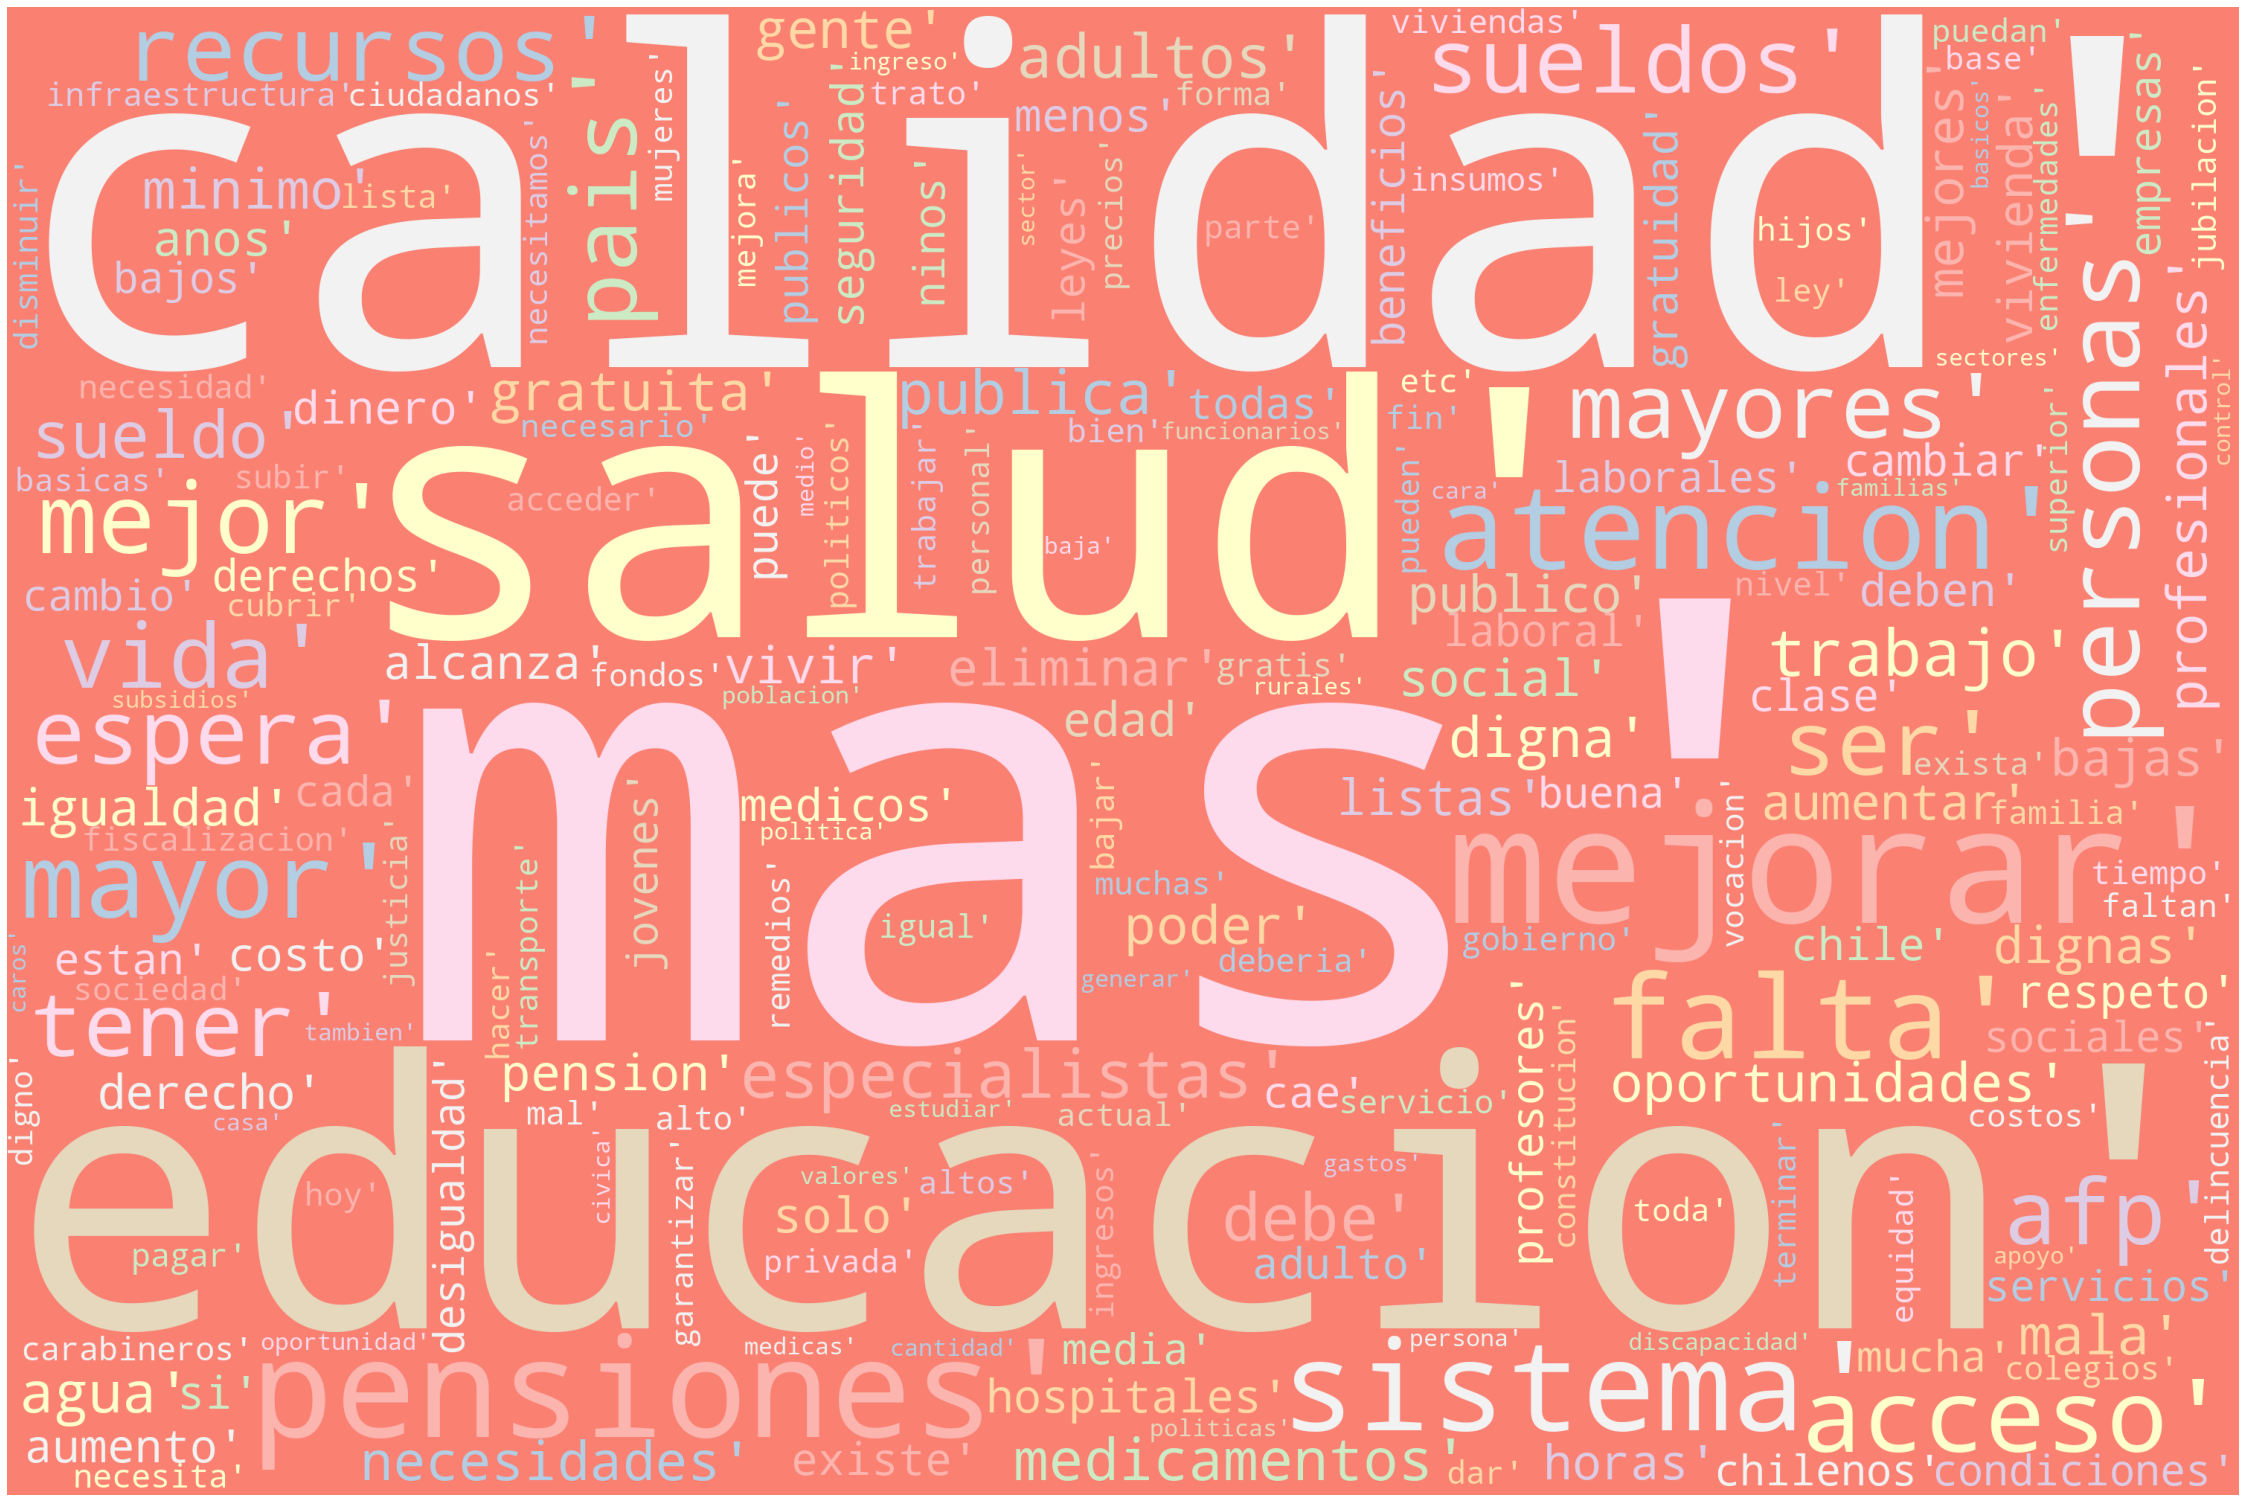

In [56]:
# Plot
plot_cloud(worcloud_text)

In [64]:
from graph_of_words import GraphOfWords
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/cridonoso/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/cridonoso/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
graph = GraphOfWords(window_size=2)
graph.build_graph(
    text,
    # OR a sentences list['Roses  are  red.', 'Violets are blue'],
    remove_stopwords=False,
    workers=4
)

In [ ]:
graph.display_graph()